# This code creates monthly plots of MIGHTI wind data vs UT

Total length of all_meridional_wind: 21450
Total length of all_zonal_wind: 21450
Total length of all_utc_time: 21450
Total length of all_local_solar_time: 21450
Total length of all_altitude: 21450


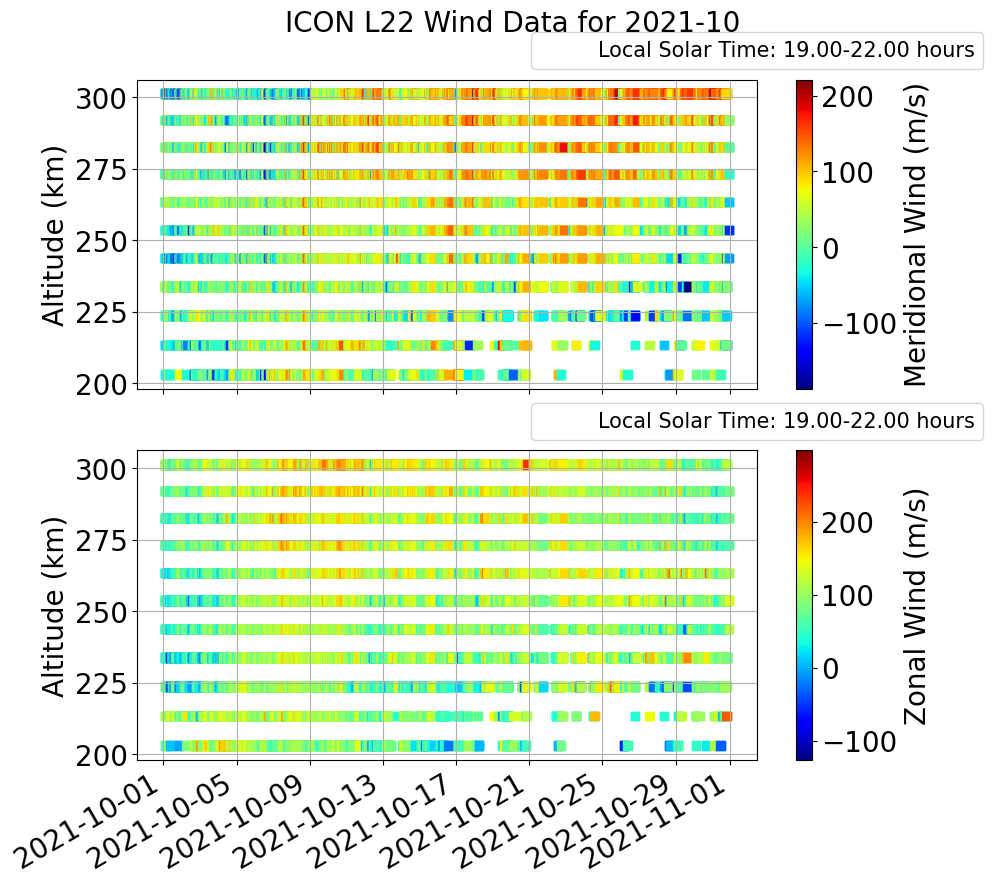

In [6]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import matplotlib.dates as mdates
from datetime import datetime

# Set the year and month here
year = 2021
month = 10

# Font size configuration
TITLE_FONT_SIZE = 20
AXIS_LABEL_FONT_SIZE = 20
TICK_LABEL_FONT_SIZE = 20
LEGEND_FONT_SIZE = 20
COLORBAR_TITLE_FONT_SIZE = 20
LEGEND_FONT_SIZE = 15


# Initialize lists to store data for the whole month
all_meridional_wind = []
all_zonal_wind = []
all_utc_time = []
all_local_solar_time = []
all_altitude = []

# Loop through each day of the month
for day in range(1, 32):
    pattern = f"/Users/gildagonzalez/Documents/Datos/ICON DATA/MIGHTI/Red line/{year}/icon_l2-2_mighti_vector-wind-red_{year}{month:02d}{day:02d}_v05r*.nc"
    files = glob.glob(pattern)

    if not files:
        print(f"No file found for {year}-{month:02d}-{day:02d}")
        continue

    filename = files[0]

    try:
        with Dataset(filename, 'r') as nc:
            meridional_wind = nc.variables['ICON_L22_Meridional_Wind'][:]
            zonal_wind = nc.variables['ICON_L22_Zonal_Wind'][:]
            utc_time = nc.variables['ICON_L22_UTC_Time'][:]
            local_solar_time = nc.variables['ICON_L22_Local_Solar_Time'][:]
            altitude = nc.variables['ICON_L22_Altitude'][:]
            wind_quality = nc.variables['ICON_L22_Wind_Quality'][:]

            utc_time = [datetime.strptime(time, "%Y-%m-%d %H:%M:%S.%fZ") for time in utc_time]

            lst_min = 19 # Initial Local Solar Time
            lst_max = 22 # Final local Solar Time
            filter_indices = np.where((local_solar_time >= lst_min) &
                                      (local_solar_time <= lst_max) &
                                      (wind_quality == 1))

            # Check if altitude is 1D and repeat it to match the other arrays' size if necessary
            if len(altitude.shape) == 1:
                altitude = np.tile(altitude, (len(utc_time), 1))

            # Append filtered data to the lists
            all_meridional_wind.extend(meridional_wind[filter_indices])
            all_zonal_wind.extend(zonal_wind[filter_indices])
            all_utc_time.extend(np.array(utc_time)[filter_indices[0]])
            all_local_solar_time.extend(local_solar_time[filter_indices])
            all_altitude.extend(altitude[filter_indices])  
    except Exception as e:
        print(f"An error occurred while processing {filename}: {e}")

# Convert lists to numpy arrays for plotting
all_meridional_wind = np.array(all_meridional_wind)
all_zonal_wind = np.array(all_zonal_wind)
all_utc_time = np.array(all_utc_time)
all_local_solar_time = np.array(all_local_solar_time)
all_altitude = np.array(all_altitude) 


# Creating stacked plots for both wind types
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Function to add legend with the range of Local Solar Times
def add_lts_legend(ax):
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='white', marker="o", markersize=0,
                              label=f'Local Solar Time: {all_local_solar_time.min():.2f}-{all_local_solar_time.max():.2f} hours')]
    ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(1, 1), fontsize=LEGEND_FONT_SIZE) 

# Plotting Meridional Wind
sc = axs[0].scatter(all_utc_time, all_altitude, c=all_meridional_wind, cmap='jet', marker=",")
axs[0].set_ylabel('Altitude (km)')
axs[0].grid(True)
#plt.colorbar(sc, ax=axs[0], label='Meridional Wind (m/s)')
add_lts_legend(axs[0])  # Added custom legend

# Plotting Zonal Wind
sc = axs[1].scatter(all_utc_time, all_altitude, c=all_zonal_wind, cmap='jet', marker=",")
axs[1].set_ylabel('Altitude (km)')
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # The date format excludes time
axs[1].grid(True)
plt.gcf().autofmt_xdate()
#plt.colorbar(sc, ax=axs[1], label='Zonal Wind (m/s)')
add_lts_legend(axs[1])  # Custom legend

# Print lengths of aggregated arrays for debugging
print(f"Total length of all_meridional_wind: {len(all_meridional_wind)}")
print(f"Total length of all_zonal_wind: {len(all_zonal_wind)}")
print(f"Total length of all_utc_time: {len(all_utc_time)}")
print(f"Total length of all_local_solar_time: {len(all_local_solar_time)}")
print(f"Total length of all_altitude: {len(all_altitude)}")

# Apply font sizes to axes labels, tick labels for both subplots
for ax in axs:
    ax.set_ylabel('Altitude (km)', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE)
    add_lts_legend(ax) 

# Plotting Meridional Wind
sc_meridional = axs[0].scatter(all_utc_time, all_altitude, c=all_meridional_wind, cmap='jet', marker=",")
cbar_meridional = plt.colorbar(sc_meridional, ax=axs[0], label='Meridional Wind (m/s)')
cbar_meridional.ax.tick_params(labelsize=TICK_LABEL_FONT_SIZE)
cbar_meridional.set_label('Meridional Wind (m/s)', fontsize=COLORBAR_TITLE_FONT_SIZE)  

# Plotting Zonal Wind
sc_zonal = axs[1].scatter(all_utc_time, all_altitude, c=all_zonal_wind, cmap='jet', marker=",")
cbar_zonal = plt.colorbar(sc_zonal, ax=axs[1], label='Zonal Wind (m/s)')
cbar_zonal.ax.tick_params(labelsize=TICK_LABEL_FONT_SIZE)
cbar_zonal.set_label('Zonal Wind (m/s)', fontsize=COLORBAR_TITLE_FONT_SIZE) 

# Adding a title for the entire plot
fig.suptitle(f'ICON L22 Wind Data for {year}-{month:02d}', fontsize=TITLE_FONT_SIZE, y=0.95) 

plt.savefig(f'/Users/gildagonzalez/Documents/Datos/STD/AGU Plots/MIGHTI/Winds_{year}-{month:02d}_postsunset.png')
plt.show()